<a href="https://colab.research.google.com/github/prog815/portfOptim/blob/master/%D0%A1_%D0%B2%D1%85%D0%BE%D0%B4%D0%BD%D1%8B%D0%BC_%D0%BD%D0%BE%D1%80%D0%BC%D0%B8%D1%80%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5%D0%BC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Загрузка библиотек

In [ ]:
! pip install bt
! pip install git+https://github.com/prog815/progGA

     |████████████████████████████████| 2.7MB 4.8MB/s 
  Created wheel for bt: filename=bt-0.2.7-cp36-cp36m-linux_x86_64.whl size=533298 sha256=301db8f9828e3771afcb16d185d3db35a1a6973f4ade14ba7082f2f620442987
  Stored in directory: /root/.cache/pip/wheels/ae/8a/a2/a679757e4e7219e6f17727d1422d4ce32da847678c6559da35
  Created wheel for ffn: filename=ffn-0.3.4-cp36-none-any.whl size=22813 sha256=fc46ae12cbd40f2a8b3a66f47ae188605adbf4c292c18331e5a01b9eab29b5d0
  Stored in directory: /root/.cache/pip/wheels/20/08/4d/921180e81279d147cb6399fe1e194f2c67a796df86f9f4c5fe
Successfully built bt ffn
  Cloning https://github.com/prog815/progGA to /tmp/pip-req-build-4gxxoezf
  Running command git clone -q https://github.com/prog815/progGA /tmp/pip-req-build-4gxxoezf
  Created wheel for progGA: filename=progGA-0.0.7-cp36-none-any.whl size=3733 sha256=c9cbb219953f925ac2108d45bf552de4880e4d13e3662137147f11477dd92910
  Stored in directory: /tmp/pip-ephem-wheel-cache-8sswthig/wheels/9c/7a/cc/d1ffa9ccaa42b

In [ ]:
import bt
from progGA import ListGenetic
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
import os

from sklearn.preprocessing import StandardScaler 

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import warnings

fn = '/content/drive/My Drive/prog/model_svn_20.11.2020.pkl'

/usr/local/lib/python3.6/dist-packages/ffn/core.py:27: MatplotlibDeprecationWarning: The 'warn' parameter of use() is deprecated since Matplotlib 3.1 and will be removed in 3.3.  If any parameter follows 'warn', they should be pass as keyword, not positionally.
  matplotlib.use('agg', warn=False)


# Загрузка истории

In [ ]:
data = bt.get('AAPL,AAL,GE,F',start='2010-01-01')
lenData = len(data)
data

,aapl,aal,ge,f
Date,,,,
2010-01-04,6.539882,4.496876,10.840267,6.937616
2010-01-05,6.551187,5.005957,10.896401,7.396526
2010-01-06,6.446983,4.798555,10.840267,7.673220
2010-01-07,6.435065,4.939965,11.401575,7.868933
2010-01-08,6.477847,4.845690,11.647147,7.889179
...,...,...,...,...
2020-11-16,120.300003,12.790000,9.570000,8.800000
2020-11-17,119.389999,12.700000,9.680000,8.750000
2020-11-18,118.029999,12.740000,9.730000,8.820000


# Алгоритм распределения

In [ ]:
def predWeights(d,lookback=10,lag=10,learnLen=300,reg = 0.0001,min_delta = 0.001,lr=0.0001,hl=100,doRate=0.5):

    n = d.shape[1]
    
    X = pd.concat([d.shift(lag+n) for n in range(1,lookback+1)],axis=1)
    #y = d.rolling(lag).mean().shift(1-lag)
    
    y = d.copy()
    def calc_mean_var_weights(data):
        try:
            res = bt.ffn.calc_mean_var_weights(data)
        except Exception:
            res = y[-1].copy() / n
        return res

    y[-lag-learnLen-1:] = d[-lag-learnLen-1:].rollapply(window=lag,fn=calc_mean_var_weights)
    y = y.shift(1-lag)

    xy = pd.concat([y,X],axis=1).dropna()

    y = xy.iloc[-learnLen:,:n]
    X = xy.iloc[-learnLen:,n:]
    
    ss_model = StandardScaler().fit(X)

    # def loss_function(y_true, y_pred):
    #     return tf.nn.relu(tf.math.reduce_mean(y_true,axis=1))-tf.math.reduce_sum(y_true * y_pred[:,:-1],axis=1)

    model = keras.Sequential([layers.Dense(hl,activation='sigmoid',input_shape=(X.shape[1],),kernel_regularizer=keras.regularizers.l2(reg)),
                              layers.Dropout(doRate),
                              layers.Dense(n,activation='softmax',kernel_regularizer=keras.regularizers.l2(reg))
                              ])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr),loss=keras.losses.mse)
    
    learn_res = model.fit(ss_model.transform(X), y, 
                          epochs=1000,
                          validation_split=0.2,
                          verbose=False,
                          use_multiprocessing=True,
                          callbacks=[keras.callbacks.EarlyStopping('val_loss',min_delta=min_delta,patience=10)])
    
    X = pd.concat([d.shift(n) for n in range(0,lookback)],axis=1)
    weights = model.predict(ss_model.transform(X))[-1]

    return weights

dData = data.to_returns()
t=1000

for n in range(10):
    weights = predWeights(dData[:t])
    print(weights,1-sum(weights))


[0.11716733 0.2987641  0.38055173 0.20351692] -8.195638656616211e-08
[0.19493008 0.2765401  0.2715007  0.2570291 ] 2.9802322387695312e-08
[0.17179768 0.17940427 0.18506742 0.46373057] 5.960464477539063e-08
[0.12069304 0.42779276 0.26820713 0.18330705] 1.4901161193847656e-08
[0.05427994 0.3335758  0.278226   0.33391827] 1.4901161193847656e-08
[0.22034042 0.2557991  0.38775286 0.13610762] -1.4901161193847656e-08
[0.14688718 0.31949353 0.28106162 0.25255764] 2.9802322387695312e-08
[0.24037111 0.3222752  0.13334924 0.30400443] 2.9802322387695312e-08
[0.12122445 0.30135873 0.29960728 0.2778096 ] -4.470348358154297e-08
[0.13591878 0.31857085 0.25562206 0.28988832] -1.4901161193847656e-08


In [ ]:
class WeighPredTF(bt.Algo):
    def __init__(self, lookback, learnLen, reg, min_delta, lr, hl, lag, doRate):
        super(WeighPredTF, self).__init__()

        self.lookback = lookback
        self.learnLen = learnLen
        self.reg = reg
        self.min_delta = min_delta
        self.lr = lr
        self.hl = hl
        self.lag = lag
        self.doRate = doRate

    def __call__(self, target):
        
        selected = target.temp['selected']
        n = len(selected)

        if n == 0:
            target.temp['weights'] = {}
        else:
            w = 1.0 / n
            target.temp['weights'] = {x: w for x in selected}
        
        d = target.universe[selected].to_returns()
        
        weights = predWeights(d,
                              lookback=self.lookback,
                              lag=self.lag,
                              learnLen=self.learnLen,
                              reg=np.power(10,self.reg),
                              min_delta=np.power(10,self.min_delta),
                              lr=np.power(10,self.lr),
                              hl=self.hl,
                              doRate=self.doRate)

        target.temp['weights'] = pd.Series({d.columns[i]: weights[i] for i in range(n)}).dropna()
        
        return True

# Поиск гиперпараметров

## Целевая функция

In [ ]:
def getQualityMethod(lookback,learnLen,reg,min_delta,lr,hl,lag,doRate):

    t = np.random.randint(2*lag+learnLen+lookback+1,lenData-1-2*lag)
    
    weights = predWeights(dData[:t],
                          lookback=lookback,
                          lag=lag,
                          learnLen=learnLen,
                          reg=np.power(10,reg),
                          min_delta=np.power(10,min_delta),
                          lr=np.power(10,lr),
                          hl=hl,
                          doRate=doRate)
    
    d = dData[t:(t+lag)].values                # данные
    
    covar = np.cov(d,rowvar=False)
    mean = np.mean(d,axis=0)
    
    var = np.dot(np.dot(weights, covar), weights)
    
    weights_r = np.ones_like(weights) / covar.shape[0]
    var_r = np.dot(np.dot(weights_r, covar), weights_r)

    koef = np.dot(mean,weights) / np.sqrt(var)
    koef_r = np.dot(mean,weights_r) / np.sqrt(var_r)
    
    # print(koef,koef_r)

    return koef - koef_r

## Создание модели

In [ ]:
modelGA = ListGenetic(pop_size=200,
                      lookback=range(30,300),
                      learnLen=range(50,500),
                      reg=np.arange(-7.0,-0.5,0.01),
                      min_delta=np.arange(-7.0,-0.5,0.01),
                      lr=np.arange(-7.0,-0.1,0.01),
                      hl=range(10,1000),
                      lag=range(10,200),
                      doRate=np.arange(0.01,1.0,0.01),
                      quality_method=getQualityMethod)

if os.path.exists(fn):
    with open(fn,'rb') as fp:
        modelGA = pickle.load(fp)

## Бесконечный цикл поиска

In [ ]:
import logging
logging.getLogger('tensorflow').disabled = True

while True:
    modelGA.fit(10,echo_time=60)
    with open(fn,'wb') as fp:
        pickle.dump(modelGA,fp)

finish -  14030 {'quality': 0.15981256994722626, 'lookback': 202, 'learnLen': 186, 'reg': -5.11000000000004, 'min_delta': -3.7300000000000697, 'lr': -3.3700000000000774, 'hl': 777, 'lag': 41, 'doRate': 0.9500000000000001}
finish -  14040 {'quality': 0.05882006336179718, 'lookback': 172, 'learnLen': 188, 'reg': -4.840000000000046, 'min_delta': -4.780000000000047, 'lr': -3.1300000000000825, 'hl': 805, 'lag': 60, 'doRate': 0.9600000000000001}
finish -  14050 {'quality': -0.061759654903697045, 'lookback': 174, 'learnLen': 211, 'reg': -5.440000000000033, 'min_delta': -4.520000000000053, 'lr': -3.300000000000079, 'hl': 619, 'lag': 44, 'doRate': 0.92}
finish -  14060 {'quality': 0.1079090346365487, 'lookback': 211, 'learnLen': 181, 'reg': -5.13000000000004, 'min_delta': -3.9400000000000652, 'lr': -3.72000000000007, 'hl': 590, 'lag': 48, 'doRate': 0.86}
finish -  14070 {'quality': 0.025416675514549625, 'lookback': 217, 'learnLen': 191, 'reg': -5.270000000000037, 'min_delta': -3.900000000000066

ResourceExhaustedError: ignored

## Графики

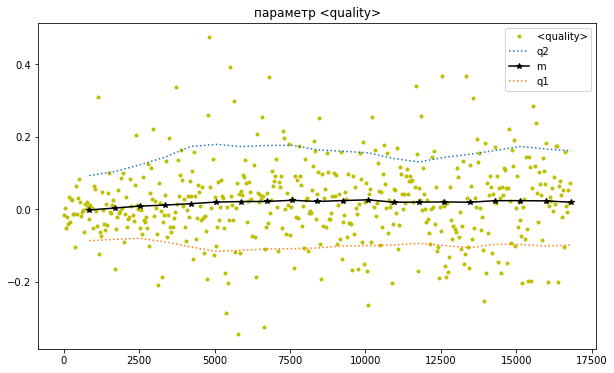

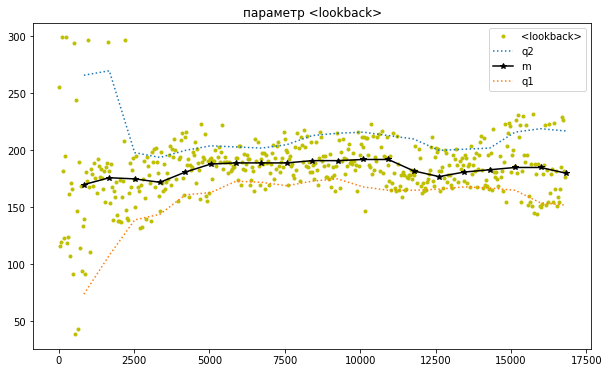

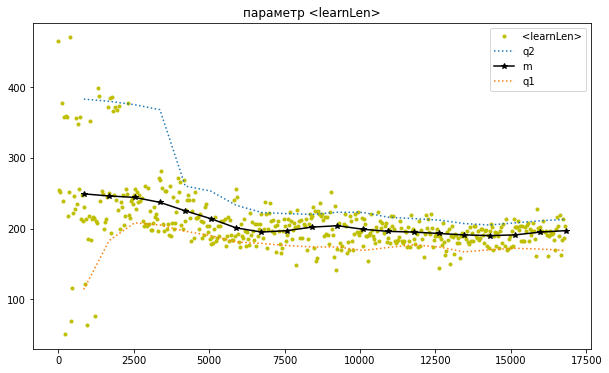

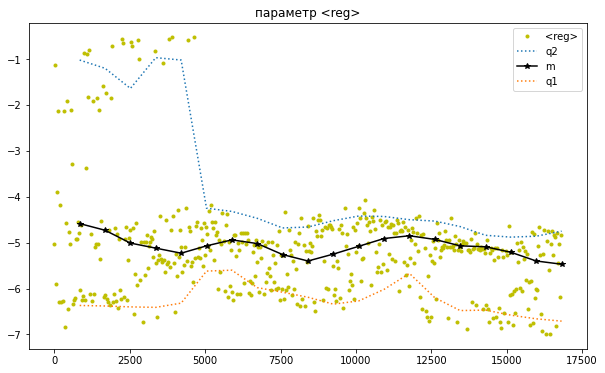

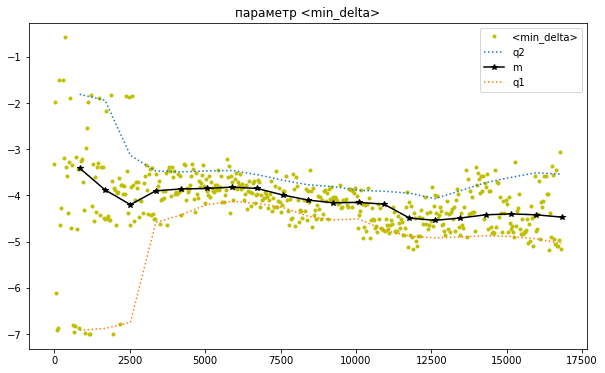

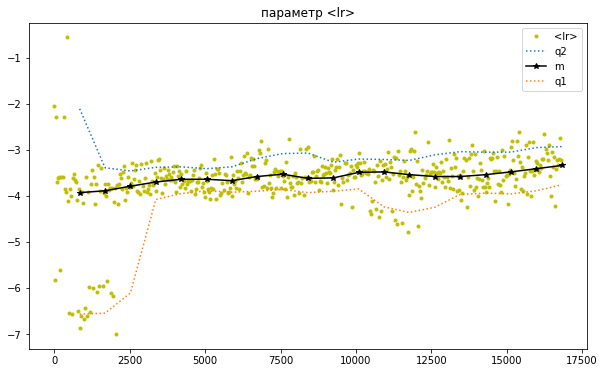

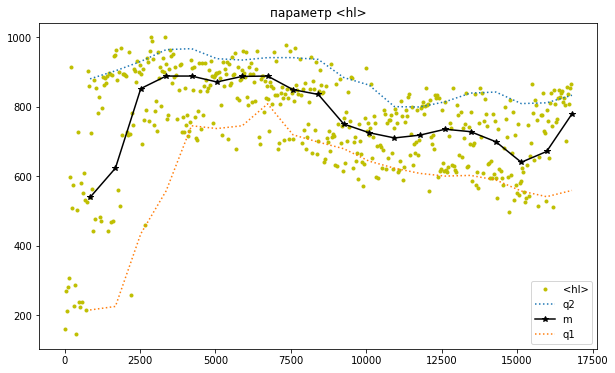

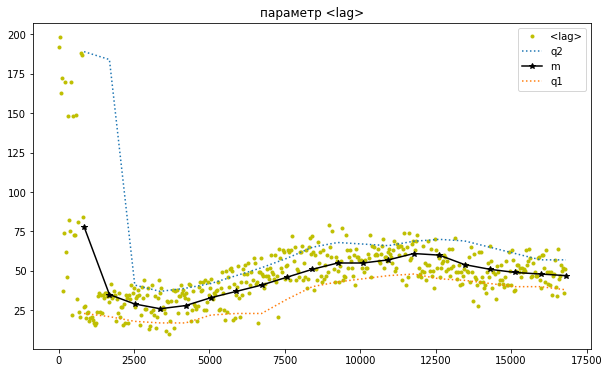

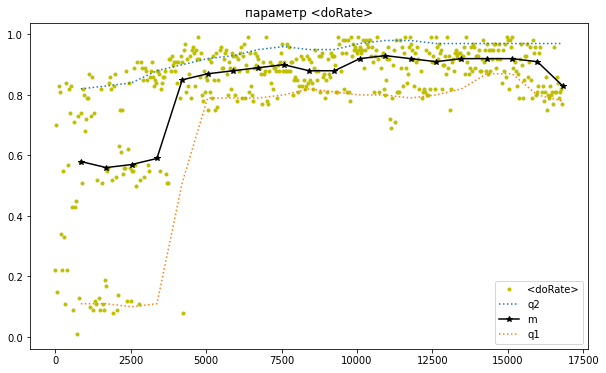

In [ ]:
modelGA.plot_hist_new(('quality','lookback','learnLen','reg','min_delta','lr','hl','lag','doRate'))


## Параметры лучшей

In [ ]:
best_par = modelGA.getBestParams()
best_par

{'doRate': 0.8300000000000001,
 'hl': 797,
 'lag': 45,
 'learnLen': 195,
 'lookback': 177,
 'lr': -3.290000000000079,
 'min_delta': -4.580000000000052,
 'reg': -5.640000000000029}

# Прогон лучшей

In [ ]:
lookback_best = best_par['lookback']
lag_best = best_par['lag']
learnLen_best = best_par['learnLen']
reg_best = best_par['reg']
min_delta_best = best_par['min_delta']
lr_best = best_par['lr']
hl_best = best_par['hl']
doRate_best = best_par['doRate']

s_best = bt.Strategy('лучший', [bt.algos.RunEveryNPeriods(lag_best,offset=lag_best*2+learnLen_best+lookback_best+1),
                                bt.algos.SelectAll(),
                                WeighPredTF(lookback=lookback_best,
                                            learnLen=learnLen_best,
                                            reg=reg_best,
                                            min_delta=min_delta_best,
                                            lr=lr_best,
                                            hl=hl_best,
                                            lag=lag_best,
                                            doRate=doRate_best),
                                bt.algos.Rebalance()])
test_best = bt.Backtest(s_best, data)

s0 = bt.Strategy('равновесный', [bt.algos.RunEveryNPeriods(lag_best,offset=lag_best+learnLen_best+lookback_best+1),
                                 bt.algos.SelectAll(),
                                 bt.algos.WeighEqually(),
                                 bt.algos.Rebalance()])
test0 = bt.Backtest(s0, data)

res_best = bt.run(test_best,test0)

лучший
0% [############################# ] 100% | ETA: 00:00:04равновесный
0% [############################# ] 100% | ETA: 00:00:00

## График баланса

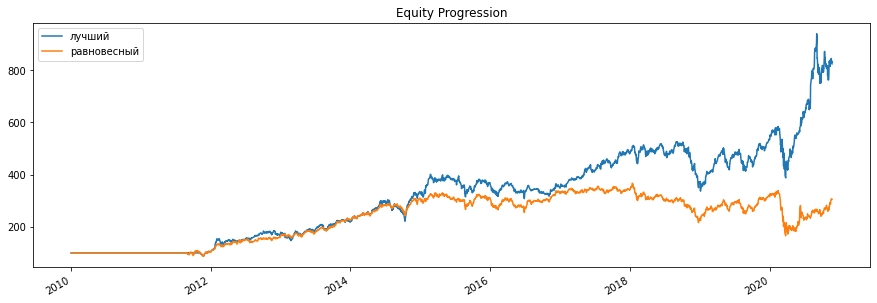

In [ ]:
res_best.plot()

## график распределения долей

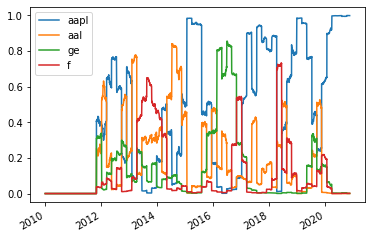

In [ ]:
res_best.get_security_weights().plot()

## график распределения свободной доли

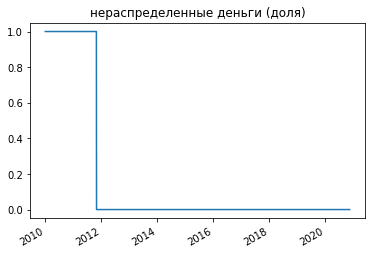

In [ ]:
w = res_best.get_weights(0)
w['деньги'] = 1-w.values[:,1:].sum(axis=1)
w['деньги'].plot()
plt.title('нераспределенные деньги (доля)')
del(w)

## итог

In [ ]:
res_best.display()

Stat                 лучший      равновесный
-------------------  ----------  -------------
Start                2010-01-03  2010-01-03
End                  2020-11-20  2020-11-20
Risk-free rate       0.00%       0.00%

Total Return         724.03%     204.81%
Daily Sharpe         0.91        0.55
Daily Sortino        1.46        0.88
CAGR                 21.39%      10.79%
Max Drawdown         -35.98%     -54.82%
Calmar Ratio         0.59        0.20

MTD                  8.00%       16.63%
3m                   -0.55%      20.43%
6m                   47.45%      52.24%
YTD                  53.40%      -4.04%
1Y                   65.96%      0.23%
3Y (ann.)            20.17%      -2.79%
5Y (ann.)            16.80%      -0.76%
10Y (ann.)           23.49%      11.79%
Since Incep. (ann.)  21.39%      10.79%

Daily Sharpe         0.91        0.55
Daily Sortino        1.46        0.88
Daily Mean (ann.)    22.45%      13.11%
Daily Vol (ann.)     24.74%      23.97%
Daily Skew           0.01  

Енин А.В.

Оренбург